# Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from typing import List


repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

from alinemol.utils import eval_roc_auc, eval_pr_auc, eval_acc, rescale, compute_linear_fit
from alinemol.utils import plot_ID_OOD, plot_ID_OOD_sns #visualize_chemspace
from alinemol.utils import split_molecules_train_test, split_molecules_train_val_test

In [2]:
#from alinemol.splitters import ScaffoldSplit, RandomSplit, SphereExclusionSplit, KMeansSplit, DBScanSplit, OptiSimSplit

#light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
#dark_color = "black"


#matplotlib.use("pgf")

# Set matplotlib parameters
rcparams = {
    # LaTeX setup
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "pgf.rcfonts": False,
    
    # Font settings
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    
    # Figure settings
    "figure.dpi": 300,  # Higher DPI for better quality
    "figure.figsize": [6.4, 4.8],  # Default figure size
    "figure.constrained_layout.use": True,  # Better layout handling
    
    # Axes settings
    "axes.linewidth": 1.0,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    
    # Legend settings
    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.loc": "upper right",
    
    # Tick settings
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
matplotlib.rcParams.update(rcparams)

# Seaborn settings
sns.set_style("whitegrid", rc=rcparams)
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)

In [3]:
# read the results that are saved in the results folder. This is used for the visualization
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv")) 

# Load the configuration file (wich contains datasets, models, and splitting)
CFG = yaml.safe_load(open(os.path.join(DATASET_PATH, "config.yml"), "r"))

ML_MODELS: List = CFG["models"]["ML"]
GNN_MODELS: List = CFG["models"]["GNN"]["scratch"]
PRETRAINED_GNN_MODELS: List = CFG["models"]["GNN"]["pretrained"]
ALL_MODELS: List = [ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS]
DATASET_NAMES: List = CFG["datasets"]["TDC"]
SPLIT_TYPES: List = CFG["splitting"]    

# Visualize the splits in 2D

In [19]:
# Function for visulizing the chemical space (available in utils/plot_utils.py)
import umap
import datamol as dm
from typing import List

def visualize_chemspace(
    data: pd.DataFrame, split_names: List[str], mol_col: str = "smiles", size_col=None, size=10, normalize=False
) -> None:
    """
    Visualize chemical space using UMAP

    Args:
        data (pd.DataFrame): pd.DataFrame with columns "smiles", "label", "split"
        split_names (list): list of split names
        mol_col (str): name of column containing SMILES
        size_col: name of column containing size information

    Returns:
        None

    Note:
        This UMAP embedding is based on the Morgan fingerprint of the molecules (r=2, n=2048)
    """
    features = [dm.to_fp(mol) for mol in data[mol_col]]
    if normalize:
        features = StandardScaler().fit_transform(features)
    embedding = umap.UMAP().fit_transform(features)
    print(embedding.shape)
    data["UMAP_0"], data["UMAP_1"] = embedding[:, 0], embedding[:, 1]
    for split_name in split_names:
        plt.figure(figsize=(10, 6))
        fig = sns.scatterplot(
            data=data, x="UMAP_0", y="UMAP_1", s=size, style=size_col, hue=split_name, alpha=0.5, hue_order=["Train", "Test"]
        )
        fig.set_title(f"UMAP Embedding of compounds for {split_name} split", fontsize=20)
        fig.legend(loc="upper right")
        plt.show()

In [36]:
index = 0
dataset_categoty = "TDC"
dataset_name = "AMES"
split_types = ["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter", "molecular_logp"]

dfs = []
for i, split_type in enumerate(split_types):
    # Load the dataset
    train_df = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"train_{index}.csv"))
    print(train_df.shape)
    test_df  = pd.read_csv(os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type, f"test_{index}.csv"))
    print(test_df.shape)
    train_test_list = ["Train"]*len(train_df) + ["Test"]*len(test_df)
    df = pd.concat([train_df, test_df])
    df[split_type] = train_test_list
    print(df.shape)
    dfs.append(df)
    if i != 0:
        df = pd.merge(dfs[0], df, on=["smiles", "label"], how="outer")
        dfs[0] = df


(5564, 2)
(1593, 2)
(7157, 3)
(6441, 2)
(716, 2)
(7157, 3)
(6724, 2)
(433, 2)
(7157, 3)
(6261, 2)
(896, 2)
(7157, 3)
(4878, 2)
(2279, 2)
(7157, 3)


In [37]:
df

smiles  label scaffold molecular_weight  \
0                              Br/C=C/Br      1    Train            Train   
1                              BrC(Br)Br      1    Train            Train   
2                     BrC(Br)C(Br)(Br)Br      0    Train             Test   
3                         BrC(Br)C(Br)Br      0    Train            Train   
4                            BrC/C=C\CBr      1    Train            Train   
...                                  ...    ...      ...              ...   
7152                            c1cnccn1      0    Train            Train   
7153  c1csc(-c2nc(N3CCOCC3)c3ccccc3n2)c1      1    Train            Train   
7154                             c1cscn1      0    Train            Train   
7155              c1scc2c1-c1cscc1C1NC21      1    Train            Train   
7156              c1scc2c1-c1cscc1C1OC21      1    Train            Train   

     kmeans max_dissimilarity perimeter  
0     Train              Test      Test  
1     Train              Test      Test  
2     Train              Test      Test  
3     Train              Test      Test  
4     Train              Test      Test  
...     ...               ...       ...  
7152  Train              Test      Test  
7153  Train             Train     Train  
7154  Train              Test      Test  
7155  Train             Train     Train  
7156  Train             Train     Train  

[7157 rows x 7 columns]

In [38]:
(df['scaffold'] == "Test").sum() / len(df), (df['scaffold'] == "Train").sum() / len(df)

(0.2225792929998603, 0.7774207070001398)

In [39]:
#import umap.plot
#umap.plot.points(features, labels=label)

(7157, 2)


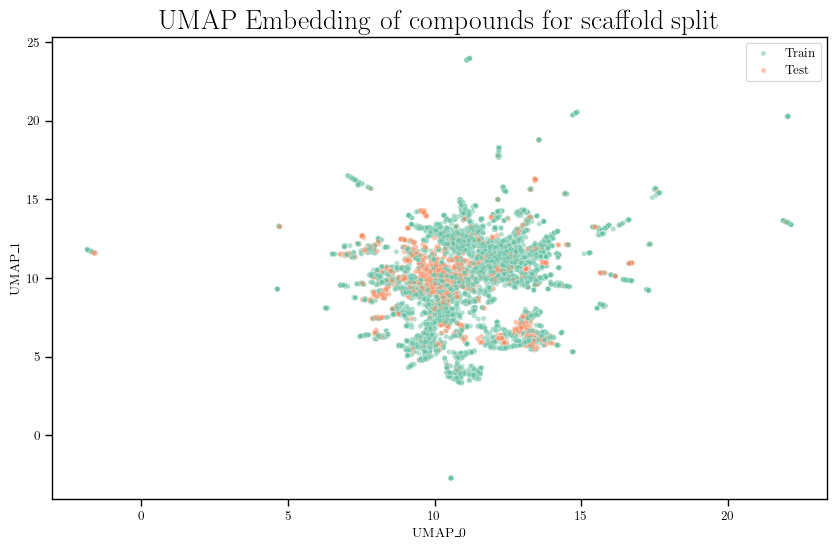

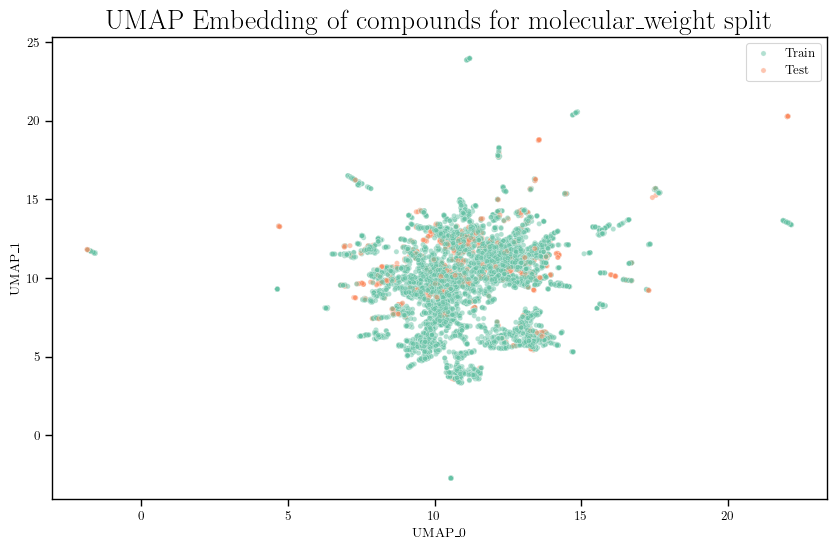

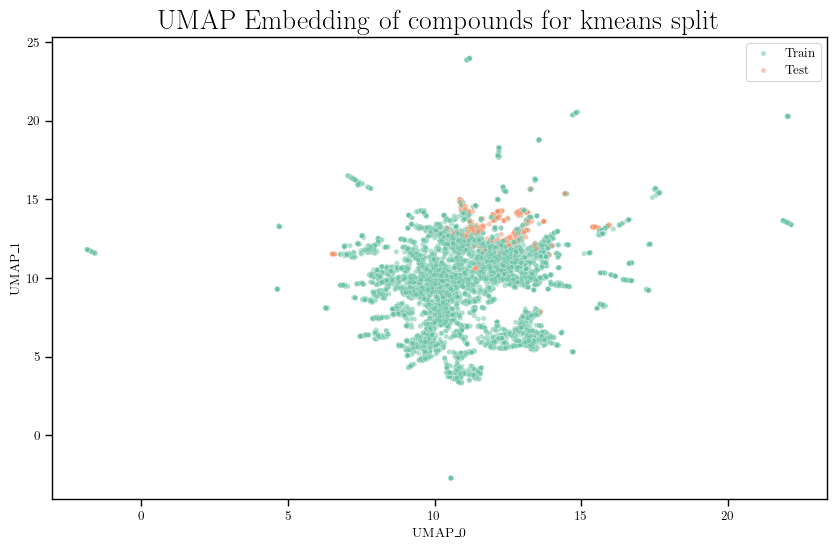

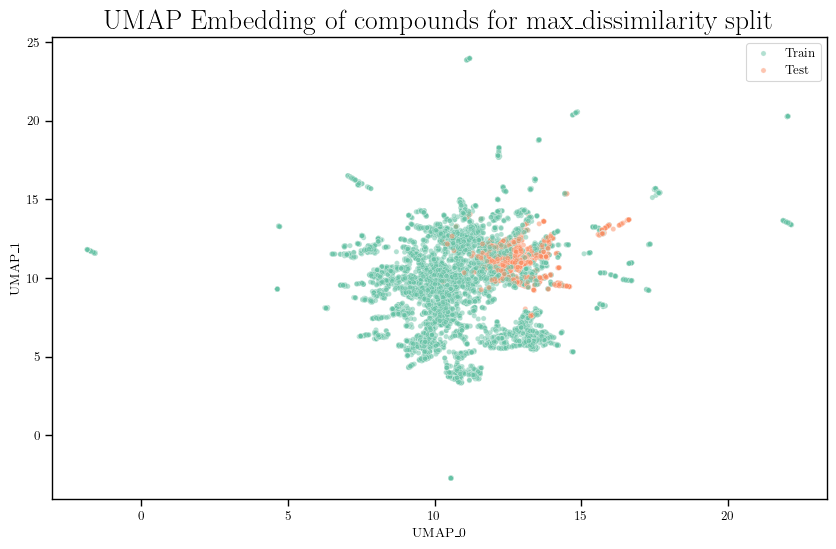

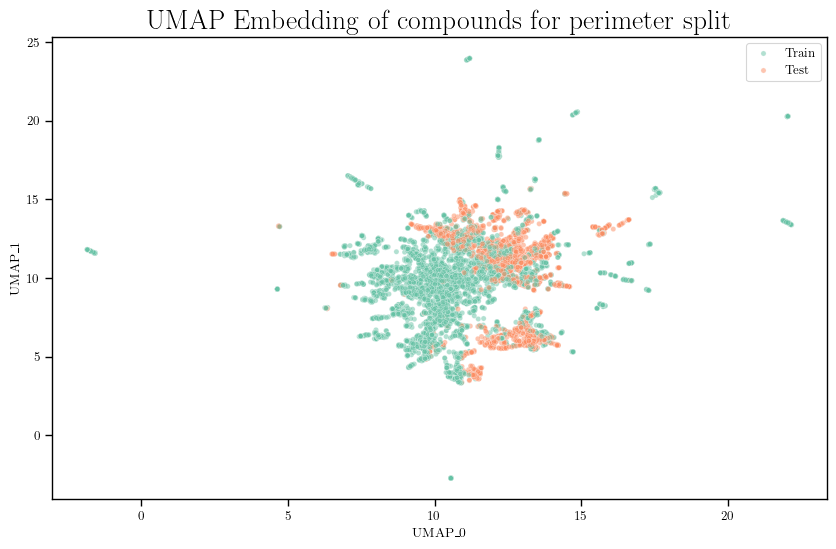

In [40]:
visualize_chemspace(df, split_names=split_types, size=14, normalize=False)

In [4]:
dataset_categoty = "TDC"
dataset_name = "CYP2C19"
split_type = "scaffold"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_categoty, dataset_name, "split", split_type)

train_path = os.path.join(SPLIT_PATH, "train_0.csv")
test_path = os.path.join(SPLIT_PATH, "test_0.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [8]:
train_test_list = ["train"]*len(train_df) + ["test"]*len(test_df)
split_df = pd.concat([train_df, test_df])
split_df[split_type] = train_test_list

In [11]:
split_df[split_type].value_counts()

scaffold
train    10026
test      2587
Name: count, dtype: int64

In [12]:
split_df

smiles  label scaffold
0            CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1      1    train
1                      Clc1ccccc1-c1n[nH]c(-c2ccccc2)n1      1    train
2       COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1      1    train
3                  COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1      1    train
4         CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1      0    train
...                                                 ...    ...      ...
2582  O=C1C2=CCc3c(c(O)n(-c4ccc(F)cc4F)c3O)[C@H]2[C@...      0     test
2583  O=C1C2=CCc3c(c(O)n(C4CCCCC4)c3O)[C@@H]2[C@H](O...      0     test
2584  O=C1[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H]1CCn1c(=...      0     test
2585  Oc1c2c(c(O)n1Cc1ccccc1)[C@H]1C(=CC2)C2(OCCCO2)...      0     test
2586                        COC(=O)NC/C=C\c1nc(CCCO)co1      0     test

[12613 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

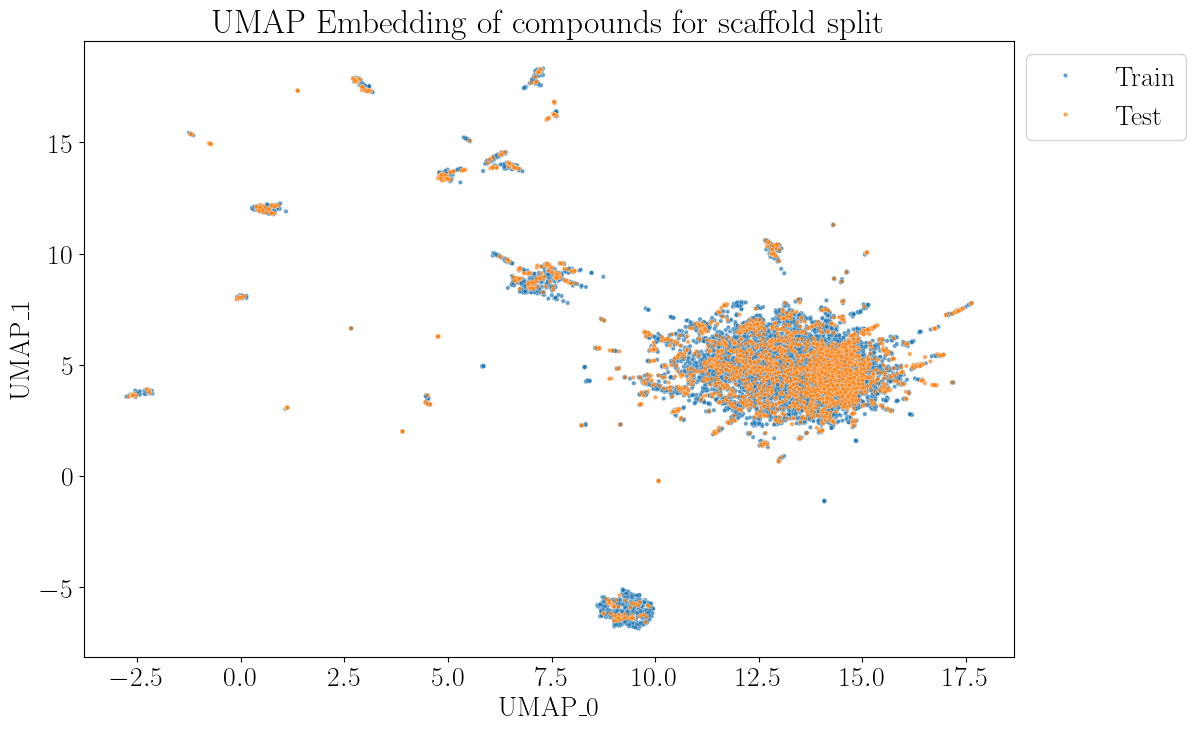

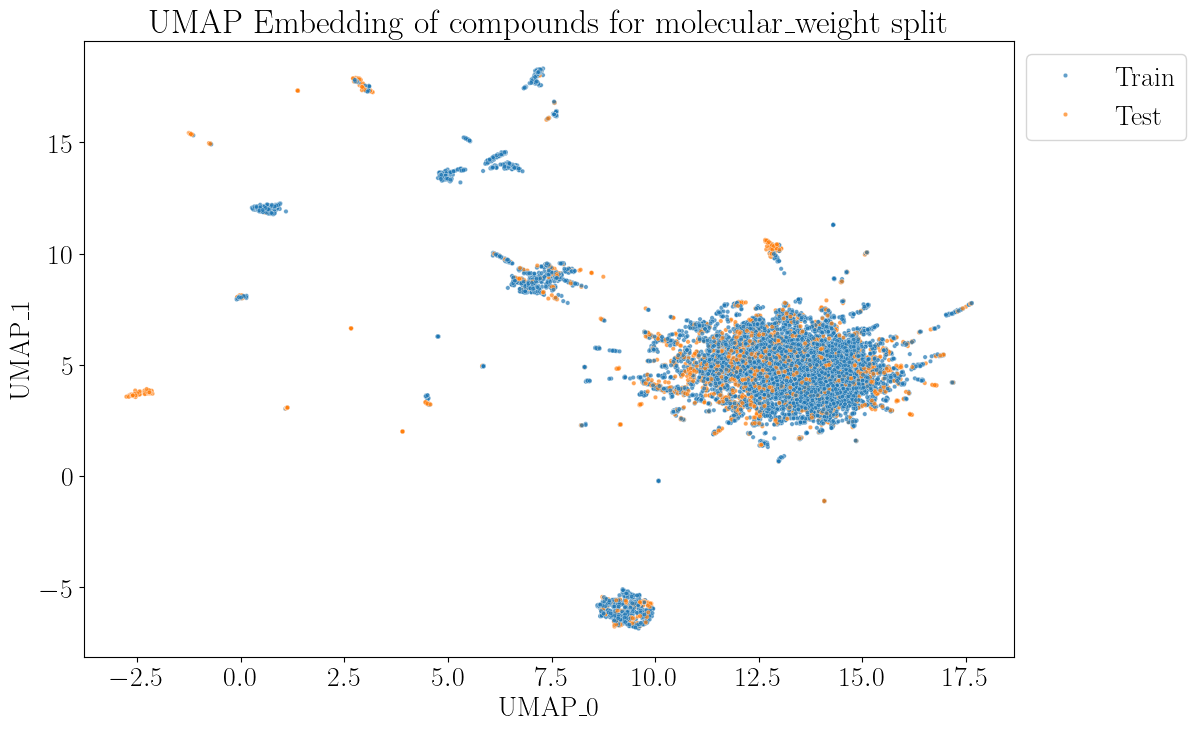

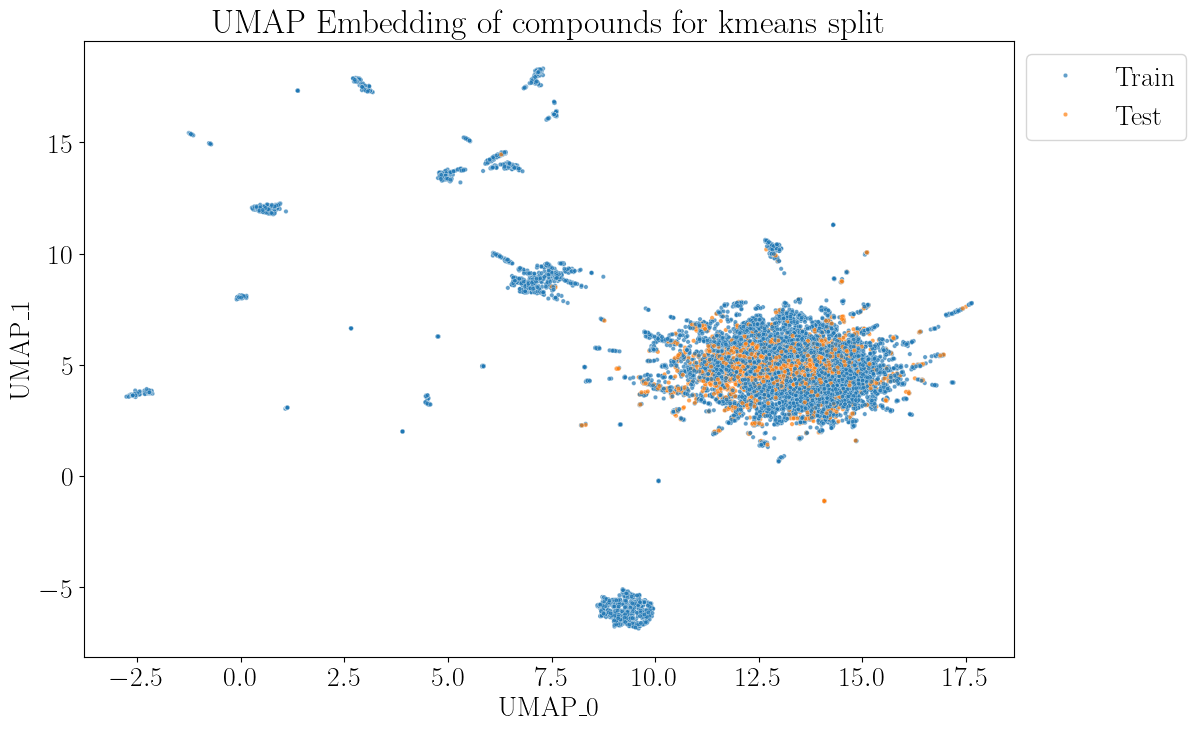

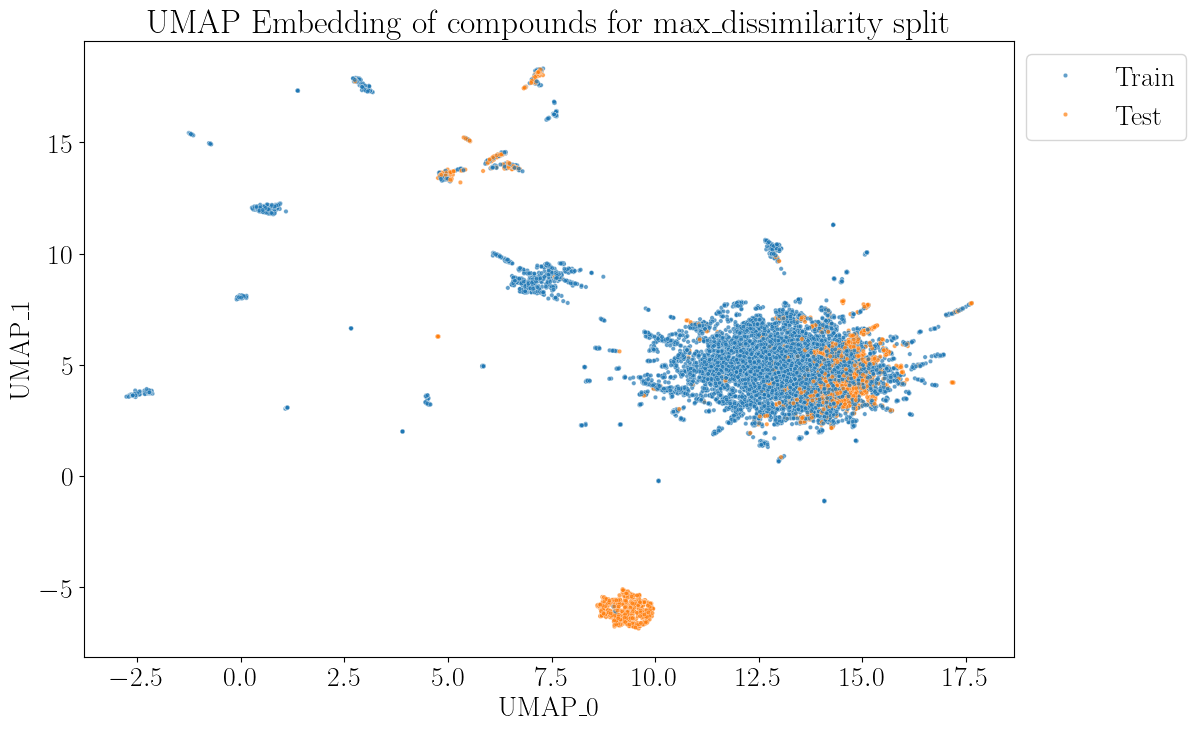

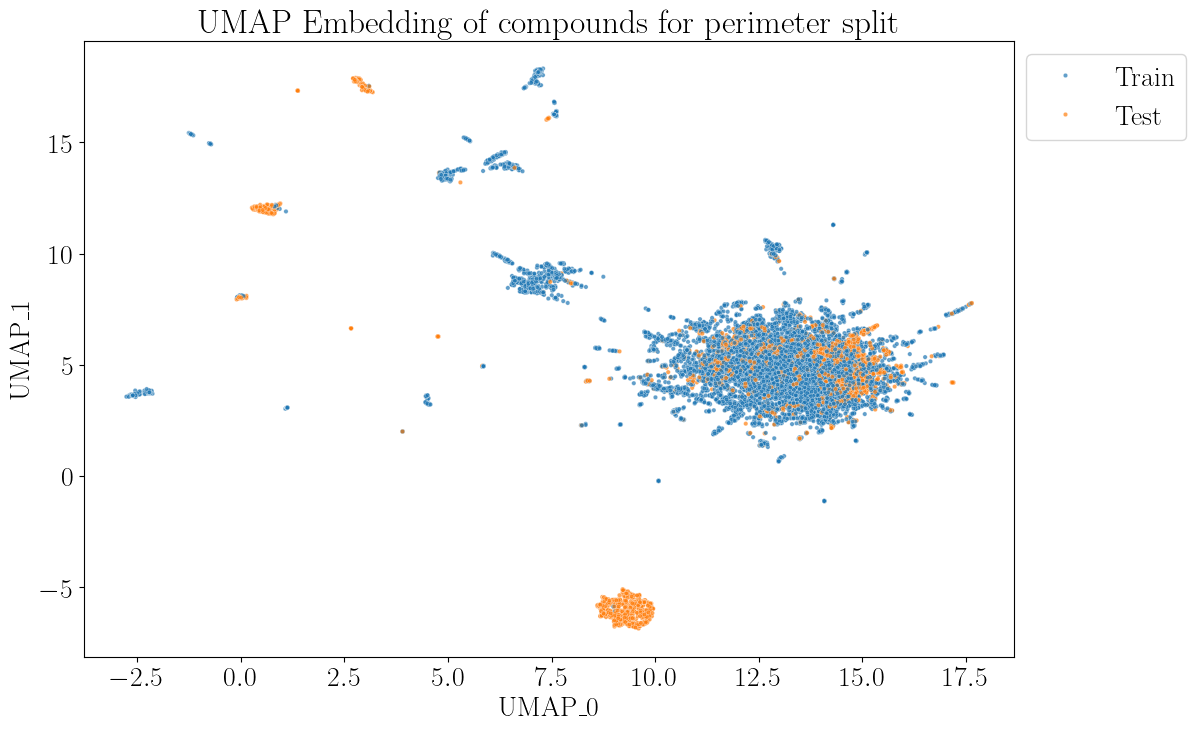

<Figure size 640x480 with 0 Axes>

In [17]:
import datamol as dm
import splito

In [18]:
DF_PATH = os.path.join(DATASET_PATH, "TDC", "CYP2C19", "CYP2C19_simplified.csv")
data = pd.read_csv(DF_PATH)
data.shape

(12665, 2)

In [19]:
# Define scaffold split
splitter = splito.ScaffoldSplit(smiles=data.smiles.tolist(), n_jobs=-1, test_size=0.1, random_state=111)

In [20]:
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))
assert train_idx.shape[0] > test_idx.shape[0]

In [21]:
data.loc[train_idx, "ScaffoldSplit"] = "train"
data.loc[test_idx, "ScaffoldSplit"] = "test"
data["scaffold"] = splitter.scaffolds

In [22]:
data["ScaffoldSplit"].value_counts()

ScaffoldSplit
train    11414
test      1251
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

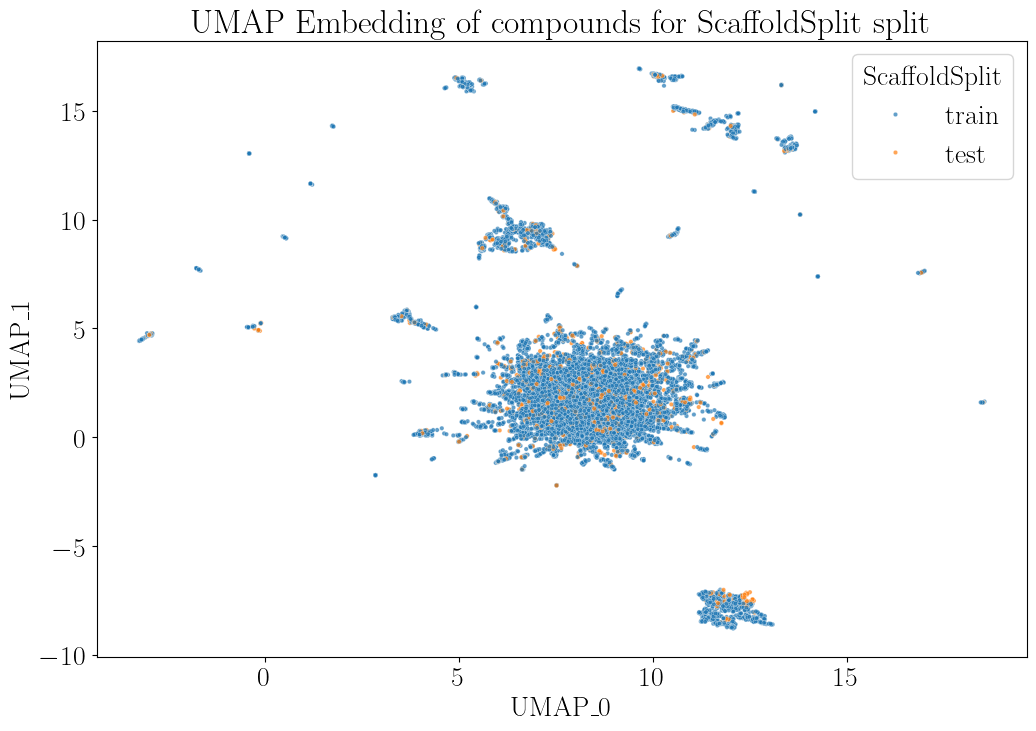

In [24]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], size=10)

In [25]:
data

smiles  label ScaffoldSplit  \
0                 CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl      0         train   
1             CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1      1         train   
2                       Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1      1         train   
3        COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1      1         train   
4                   COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1      1         train   
...                                                  ...    ...           ...   
12660  CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...      0         train   
12661  O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...      0         train   
12662  CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...      1          test   
12663  C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...      0         train   
12664                        COC(=O)NC/C=C\c1nc(CCCO)co1      0          test   

                                                scaffold    UMAP_0     UMAP_1  
0                                     c1ccc(N2CCNCC2)cc1  9.557853   3.139632  
1                     O=c1oc2ccc(NS(=O)(=O)c3cccs3)cc2s1  7.717187   1.656112  
2                       c1ccc(-c2n[nH]c(-c3ccccc3)n2)cc1  9.522059   0.786873  
3             c1ccc(C(c2nnn[nH]2)N2CCN(Cc3ccncc3)CC2)cc1  9.813725   0.699903  
4                     O=C(Cn1nnc(-c2ccncc2)n1)NCc1ccccc1  8.179121   3.715858  
...                                                  ...       ...        ...  
12660   O=C1NC(=O)[C@@H]2CC[C@@H]3C(=O)C=CC[C@H]3[C@H]12  5.097229  16.109467  
12661  O=C1[C@H]2[C@H](CC=C3[C@H]2C[C@H]2O[C@@H]2C32O...  6.363259   3.586334  
12662  O=C1NC(=O)[C@H]2CC=C3[C@@H](C[C@H]4O[C@@H]4C34...  6.338778   3.489323  
12663  O=C1CCC[C@H]2[C@@H]3C(=O)N(Cc4ccccc4)C(=O)[C@@...  5.342569  16.228552  
12664                                            c1cocn1  7.610956   1.825288  

[12665 rows x 6 columns]

In [14]:
visualize_chemspace(data, split_names=["ScaffoldSplit"], mol_col="scaffold")

NameError: name 'data' is not defined

In [ ]:
# Define PerimeterSplit
splitter = splito.PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data["smiles"].values))

assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, splito.PerimeterSplit.__name__] = "train"
data.loc[test_idx, splito.PerimeterSplit.__name__] = "test"

In [ ]:
# Define PerimeterSplit
splitter = splito.MaxDissimilaritySplit(n_jobs=-1, test_size=0.2, random_state=111)
train_idx, test_idx = next(splitter.split(X=data.smiles.values))
assert train_idx.shape[0] > test_idx.shape[0]

data.loc[train_idx, "MaxDissimilaritySplit"] = "train"
data.loc[test_idx, "MaxDissimilaritySplit"] = "test"

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

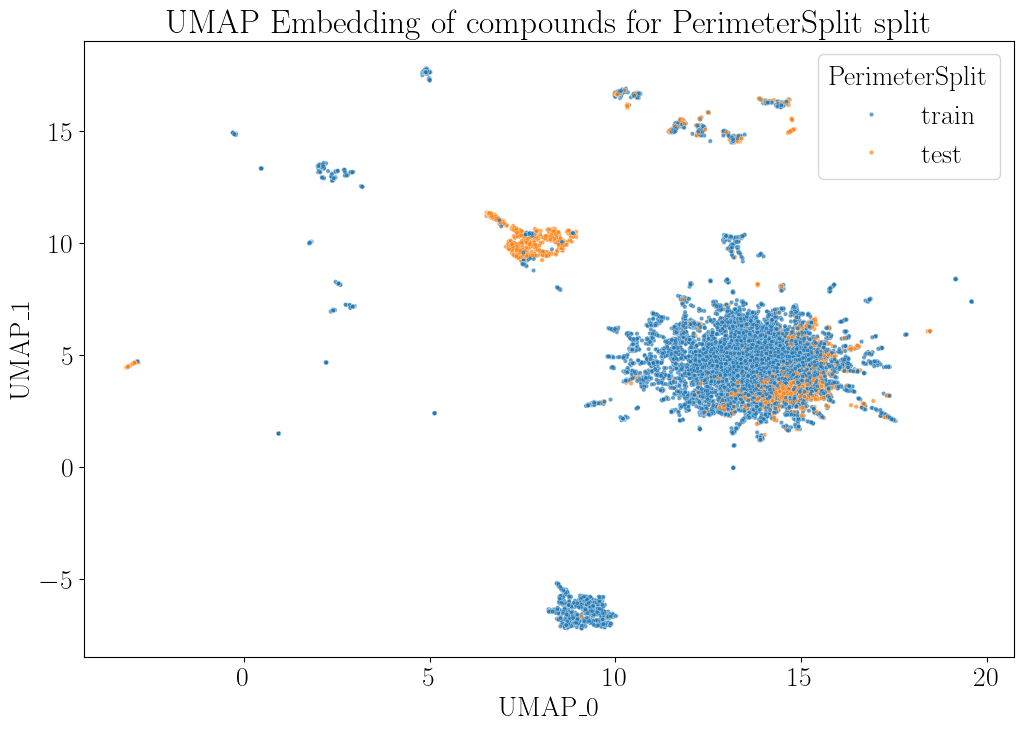

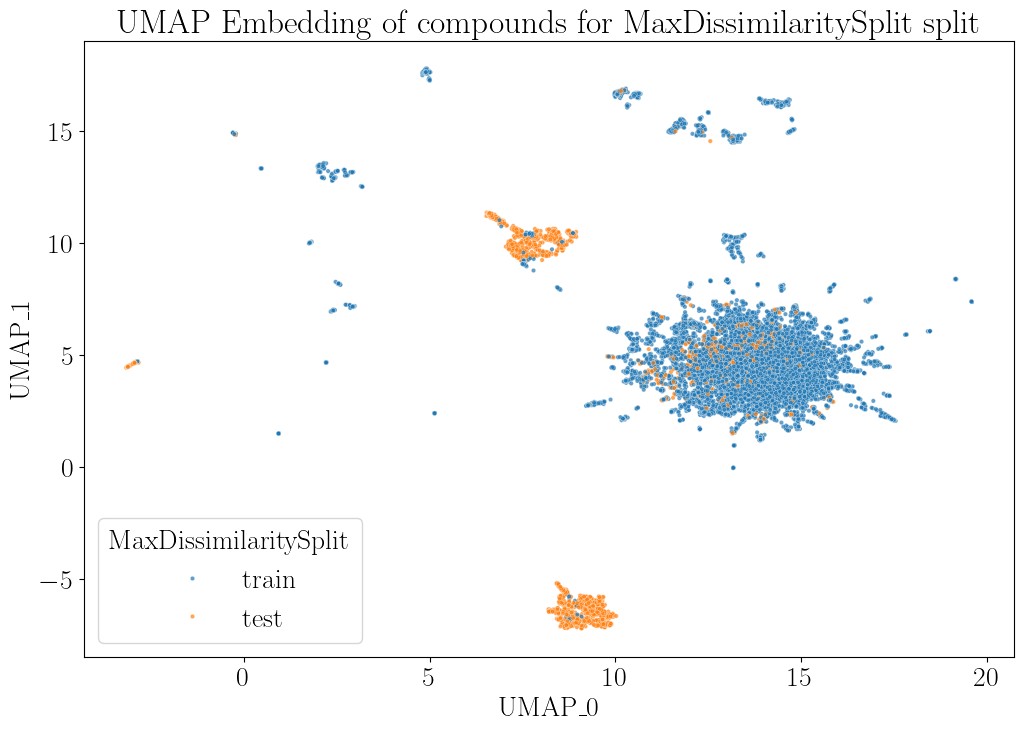

In [29]:
visualize_chemspace(data, split_names=["PerimeterSplit", "MaxDissimilaritySplit"])

##

# K- Nearest Dataset Distance

In [3]:
from alinemol.utils.split_utils import retrieve_k_nearest_neighbors_TMD, retrieve_k_nearest_neighbors_Tanimoto, train_test_dataset_distance_retrieve, sklearn_stratified_random_split
from tqdm import tqdm

cfg = yaml.safe_load(open(os.path.join("datasets", "config.yml"), "r"))
datasets = cfg["datasets"]["TDC"]
splitting = cfg["splitting"]
#splitting = ["scaffold"]
index = np.arange(10)

df_list = []
for split in tqdm(splitting):
    for dataset in datasets:
        original_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, f"{dataset}_standardize.csv"))
        pairwise_distance_jaccard = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"Jaccard_distance.npy"))
        pairwise_distance_tmd = np.load (os.path.join(DATASET_PATH, "TDC", dataset, f"TMD_distance.npy"))
        for idx in index: 
            id_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"train_{idx}.csv"))
            X, y = np.array(id_df["smiles"]), np.array(id_df["label"])
            X_train, X_val, X_test, y_train, y_val, y_test = sklearn_stratified_random_split(X, y, (0.72, 0.08, 0.2))
            train_df = pd.DataFrame({"smiles": X_train, "label": y_train})
            test_df = pd.read_csv(os.path.join(DATASET_PATH, "TDC", dataset, "split", f"{split}", f"test_{idx}.csv"))
            tanimoto_vals = retrieve_k_nearest_neighbors_Tanimoto(pairwise_distance_jaccard, original_df, train_df, test_df, k=5)
            tmd_vals = retrieve_k_nearest_neighbors_TMD(pairwise_distance_tmd, original_df, train_df, test_df, k=5)
            dist_df = pd.DataFrame({"tanimoto": tanimoto_vals, "tmd": tmd_vals, "split": split, "dataset": dataset, "index": idx})
            df_list.append(dist_df)

dist_df = pd.concat(df_list)
dist_df

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [05:14<00:00, 39.31s/it]


tanimoto     tmd              split dataset  index
0      0.186047  127.35             random  CYP1A2      0
1      0.750000  173.02             random  CYP1A2      0
2      0.531250  159.35             random  CYP1A2      0
3      0.606061  119.19             random  CYP1A2      0
4      0.581818  125.52             random  CYP1A2      0
...         ...     ...                ...     ...    ...
11015  0.692308  321.15  max_dissimilarity    HERG      9
11016  0.746988  286.91  max_dissimilarity    HERG      9
11017  0.651163  257.66  max_dissimilarity    HERG      9
11018  0.629032  175.97  max_dissimilarity    HERG      9
11019  0.693878  165.80  max_dissimilarity    HERG      9

[6231525 rows x 5 columns]

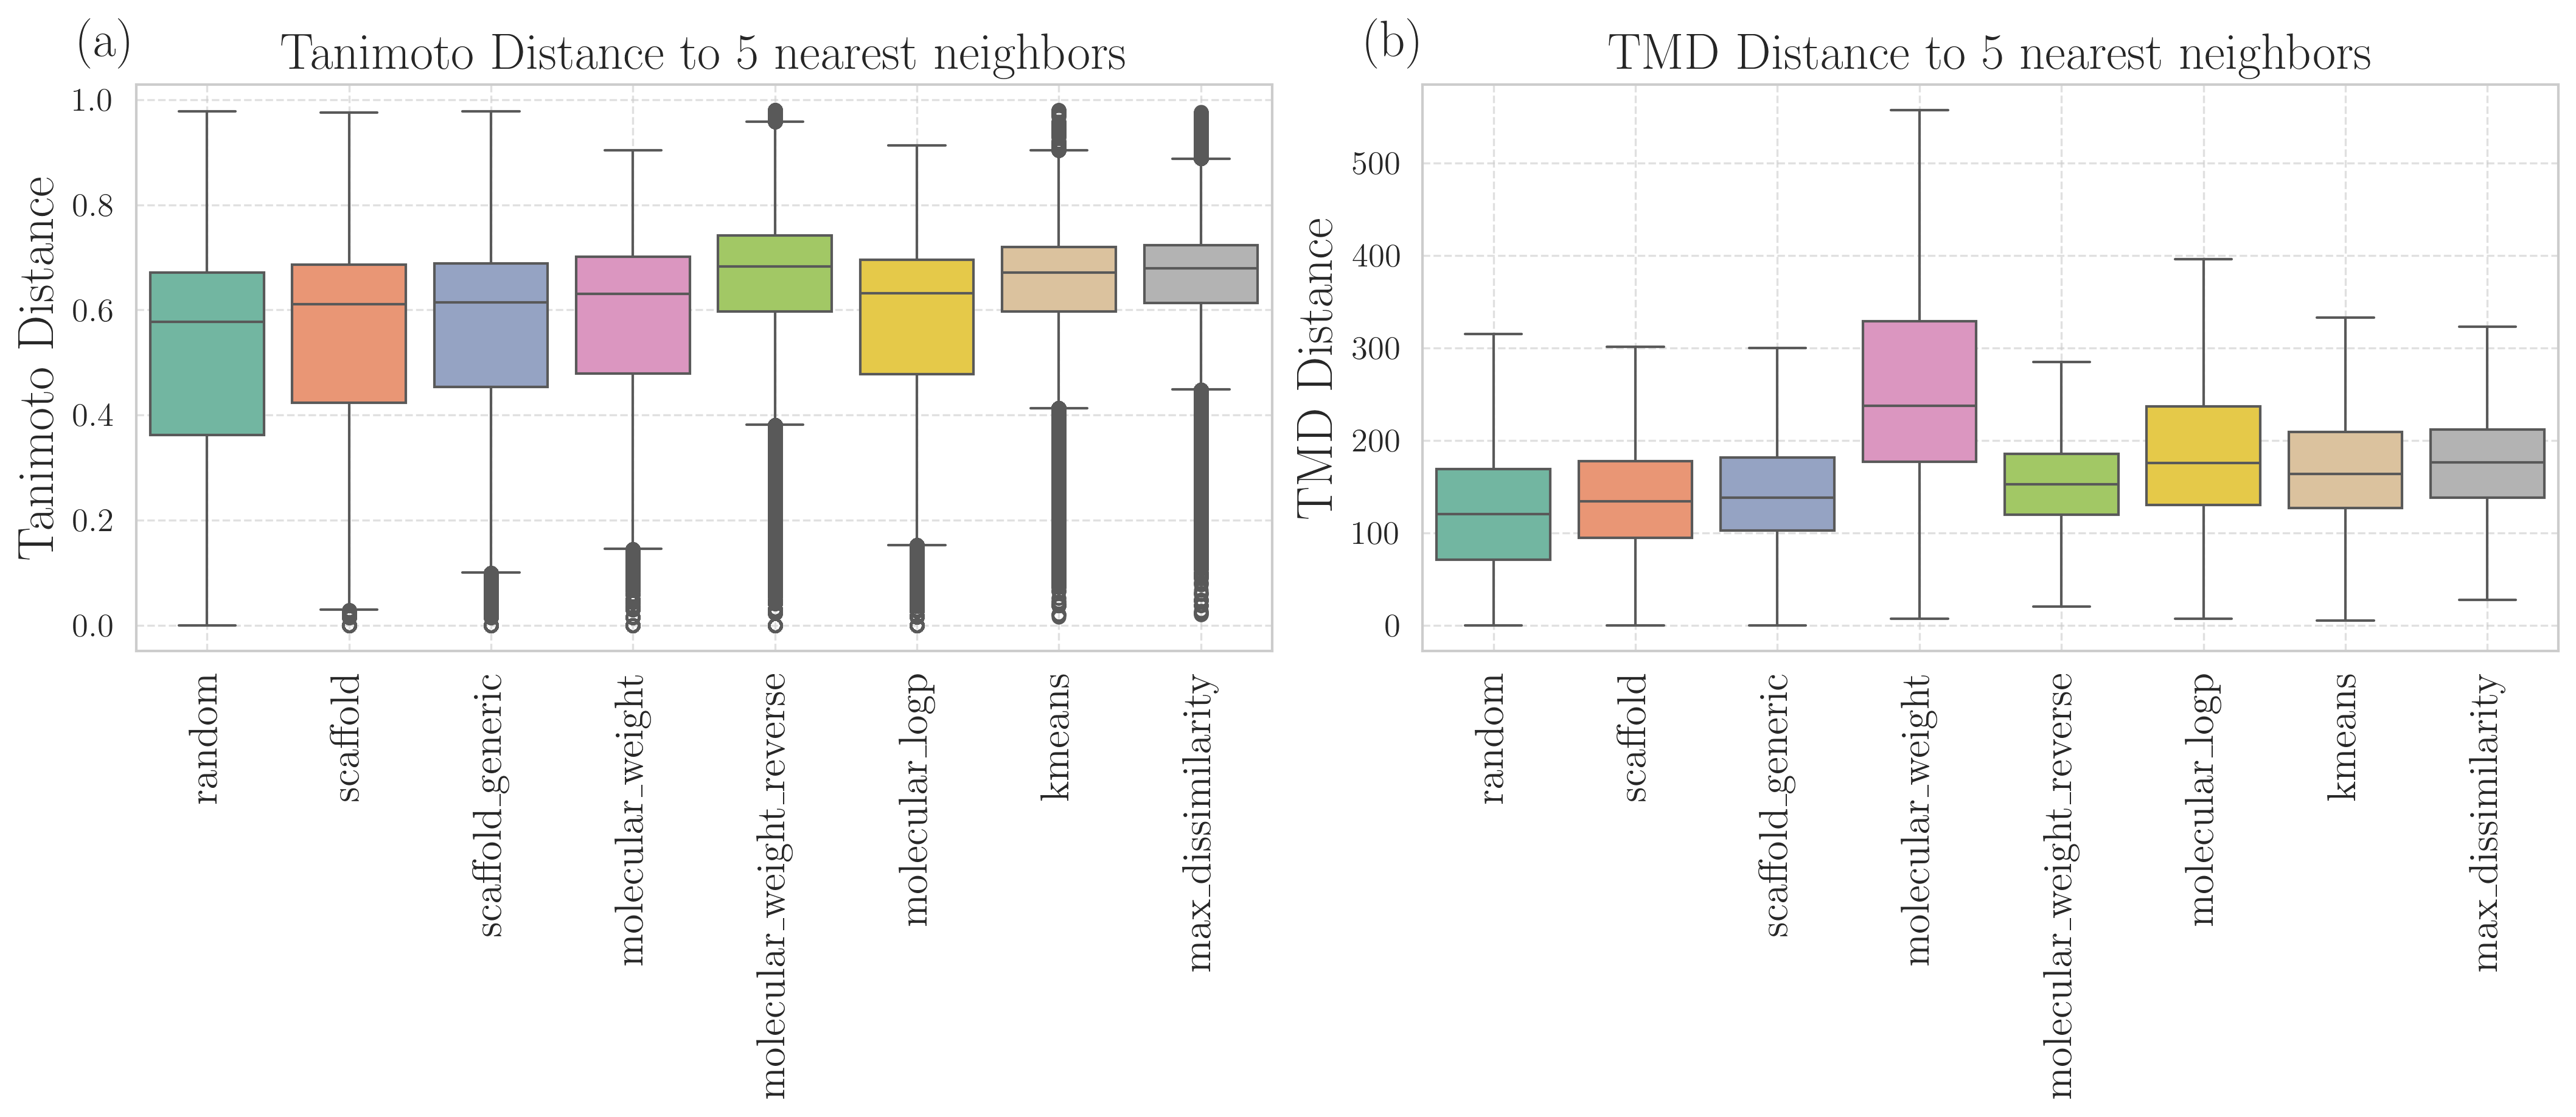

In [4]:
# Plot a Boxplot Figure (1, 2) with two horizontal axis, one for Tanimoto and one for TMD. (x-axis: split, y-axis: distance)


fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'wspace': 0.05})
sns.boxplot(x="split", y="tanimoto", data=dist_df, hue="split", ax=ax[0])
sns.boxplot(x="split", y="tmd", data=dist_df, hue="split", ax=ax[1], showfliers=False)
ax[0].set_title("Tanimoto Distance to 5 nearest neighbors", fontsize=20)
ax[1].set_title("TMD Distance to 5 nearest neighbors", fontsize=20)
ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("", fontsize=20)
ax[0].set_ylabel("Tanimoto Distance", fontsize=20)
ax[1].set_ylabel("TMD Distance", fontsize=20)
ax[0].grid(axis='both', linestyle='--', alpha=0.6)
ax[1].grid(axis='both', linestyle='--', alpha=0.6)
ax[0].tick_params(axis='x', rotation=90, labelsize=16)
ax[1].tick_params(axis='x', rotation=90, labelsize=16)

# put a and b in the top left corner of the first and second subplot (outside the plot)
ax[0].text(-0.05, 1.05, '(a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold')
ax[1].text(-0.05, 1.05, '(b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold')

save = False
# save to pdf and png
if save:
    plt.savefig("assets/distance_distribution.pdf", bbox_inches="tight")
    plt.savefig("assets/distance_distribution.png", bbox_inches="tight", dpi=300)

plt.show()

# Plot performance of ID vs OOD

/tmp/ipykernel_4032942/1552668522.py:53: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.2)


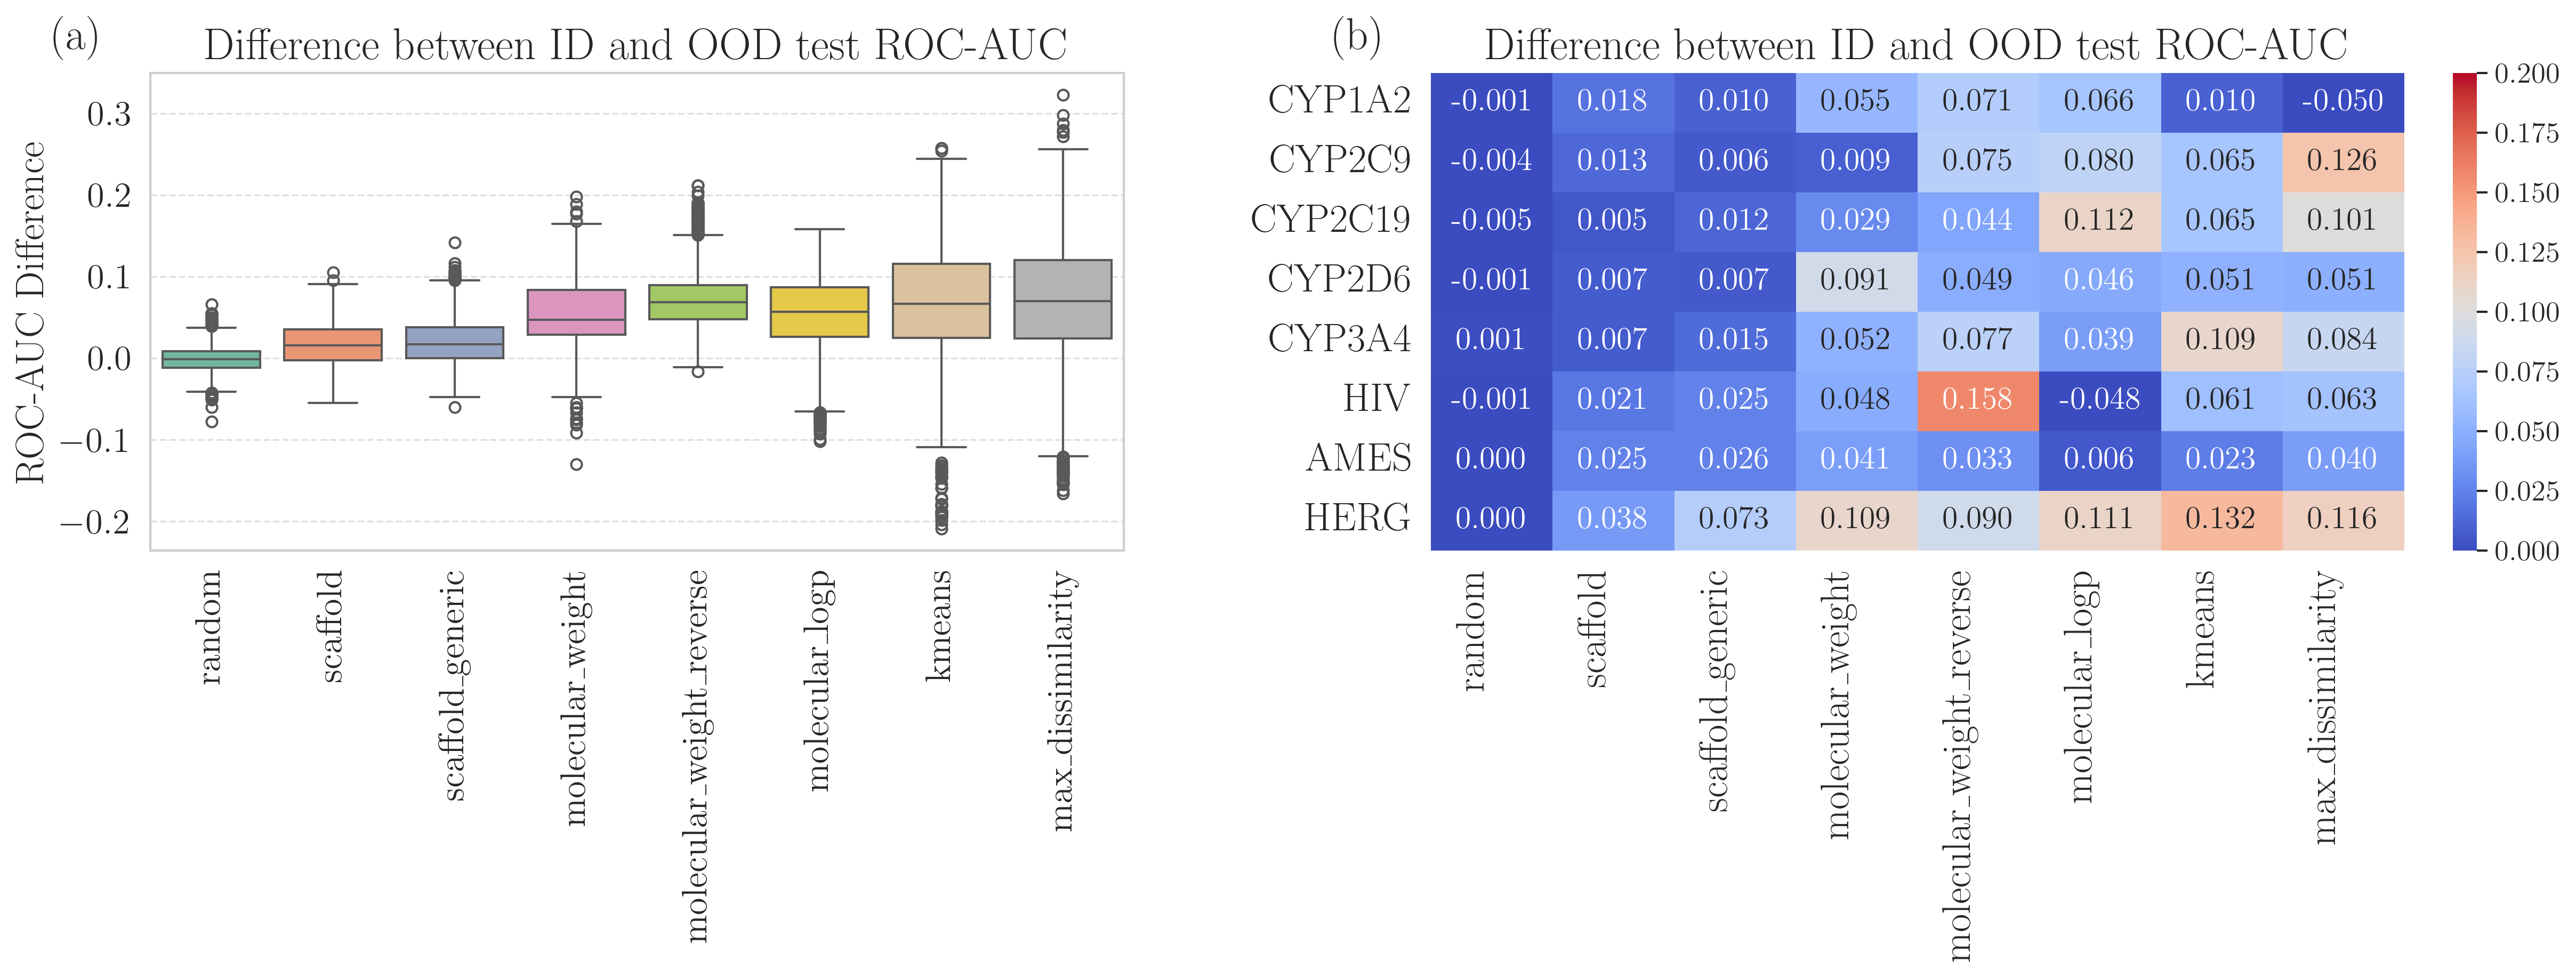

In [4]:
# First groupby by the split. Then box plot the differnce between ID_test_roc_auc and OOD_test_roc_auc for each split
# Create a single figure with two subplots
# box plots with the difference between ID and OOD test aggregated by dataset
# heatmap with the difference between ID and OOD test aggregated by dataset and split
metric = 'roc_auc'
perc = False
save = False
metric_mapping = {'accuracy': 'Accuracy', 'roc_auc': 'ROC-AUC', 'pr_auc': 'PR-AUC'}

diff = results[f"ID_test_{metric}"] - results[f"OOD_test_{metric}"]
results['difference'] = diff
# Create a single figure with two subplots with more horizontal space between them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.1})

# First subplot - Boxplot
sns.boxplot(x="split", y="difference", data=results, hue="split", ax=ax1, showfliers=True)
ax1.tick_params(axis='x', rotation=90, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax1.set_xlabel("", fontsize=24)
ax1.set_ylabel(f"{metric_mapping[metric]} Difference", fontsize=18)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
#ax1.legend().remove()  # Remove redundant legend

# Second subplot - Heatmap
dataset_names = results["dataset"].unique()
split_types = SPLIT_TYPES
df = pd.DataFrame(index=dataset_names, columns=split_types)

# Fill the dataframe
for dataset in dataset_names:
    for split in split_types:
        num = results[(results["dataset"] == dataset) & (results["split"] == split)][f"ID_test_{metric}"].mean()
        den = results[(results["dataset"] == dataset) & (results["split"] == split)][f"OOD_test_{metric}"].mean()
        df.loc[dataset, split] = num - den if not perc else (num - den) / num * 100

df = df.astype(float)

# Plot heatmap
vmin, vmax = 0.0, 0.2
sns.heatmap(df, ax=ax2, cmap="coolwarm", annot=True, fmt=".3f", vmin=vmin, vmax=vmax)
ax2.set_xlabel("", fontsize=24)
ax2.set_ylabel("", fontsize=24)
ax2.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment="right", fontsize=18)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, horizontalalignment="right", fontsize=18)

# Add subplot labels
ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold')

# Adjust layout with bottom margin
plt.subplots_adjust(bottom=0.2)

# Save if needed
if save:
    plt.savefig("assets/box_heatmap_id_ood_comparison_roc_auc.pdf", bbox_inches="tight")
    plt.savefig("assets/box_heatmap_id_ood_comparison_roc_auc.png", bbox_inches="tight", dpi=300)

plt.show()

/tmp/ipykernel_4032942/2484186775.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


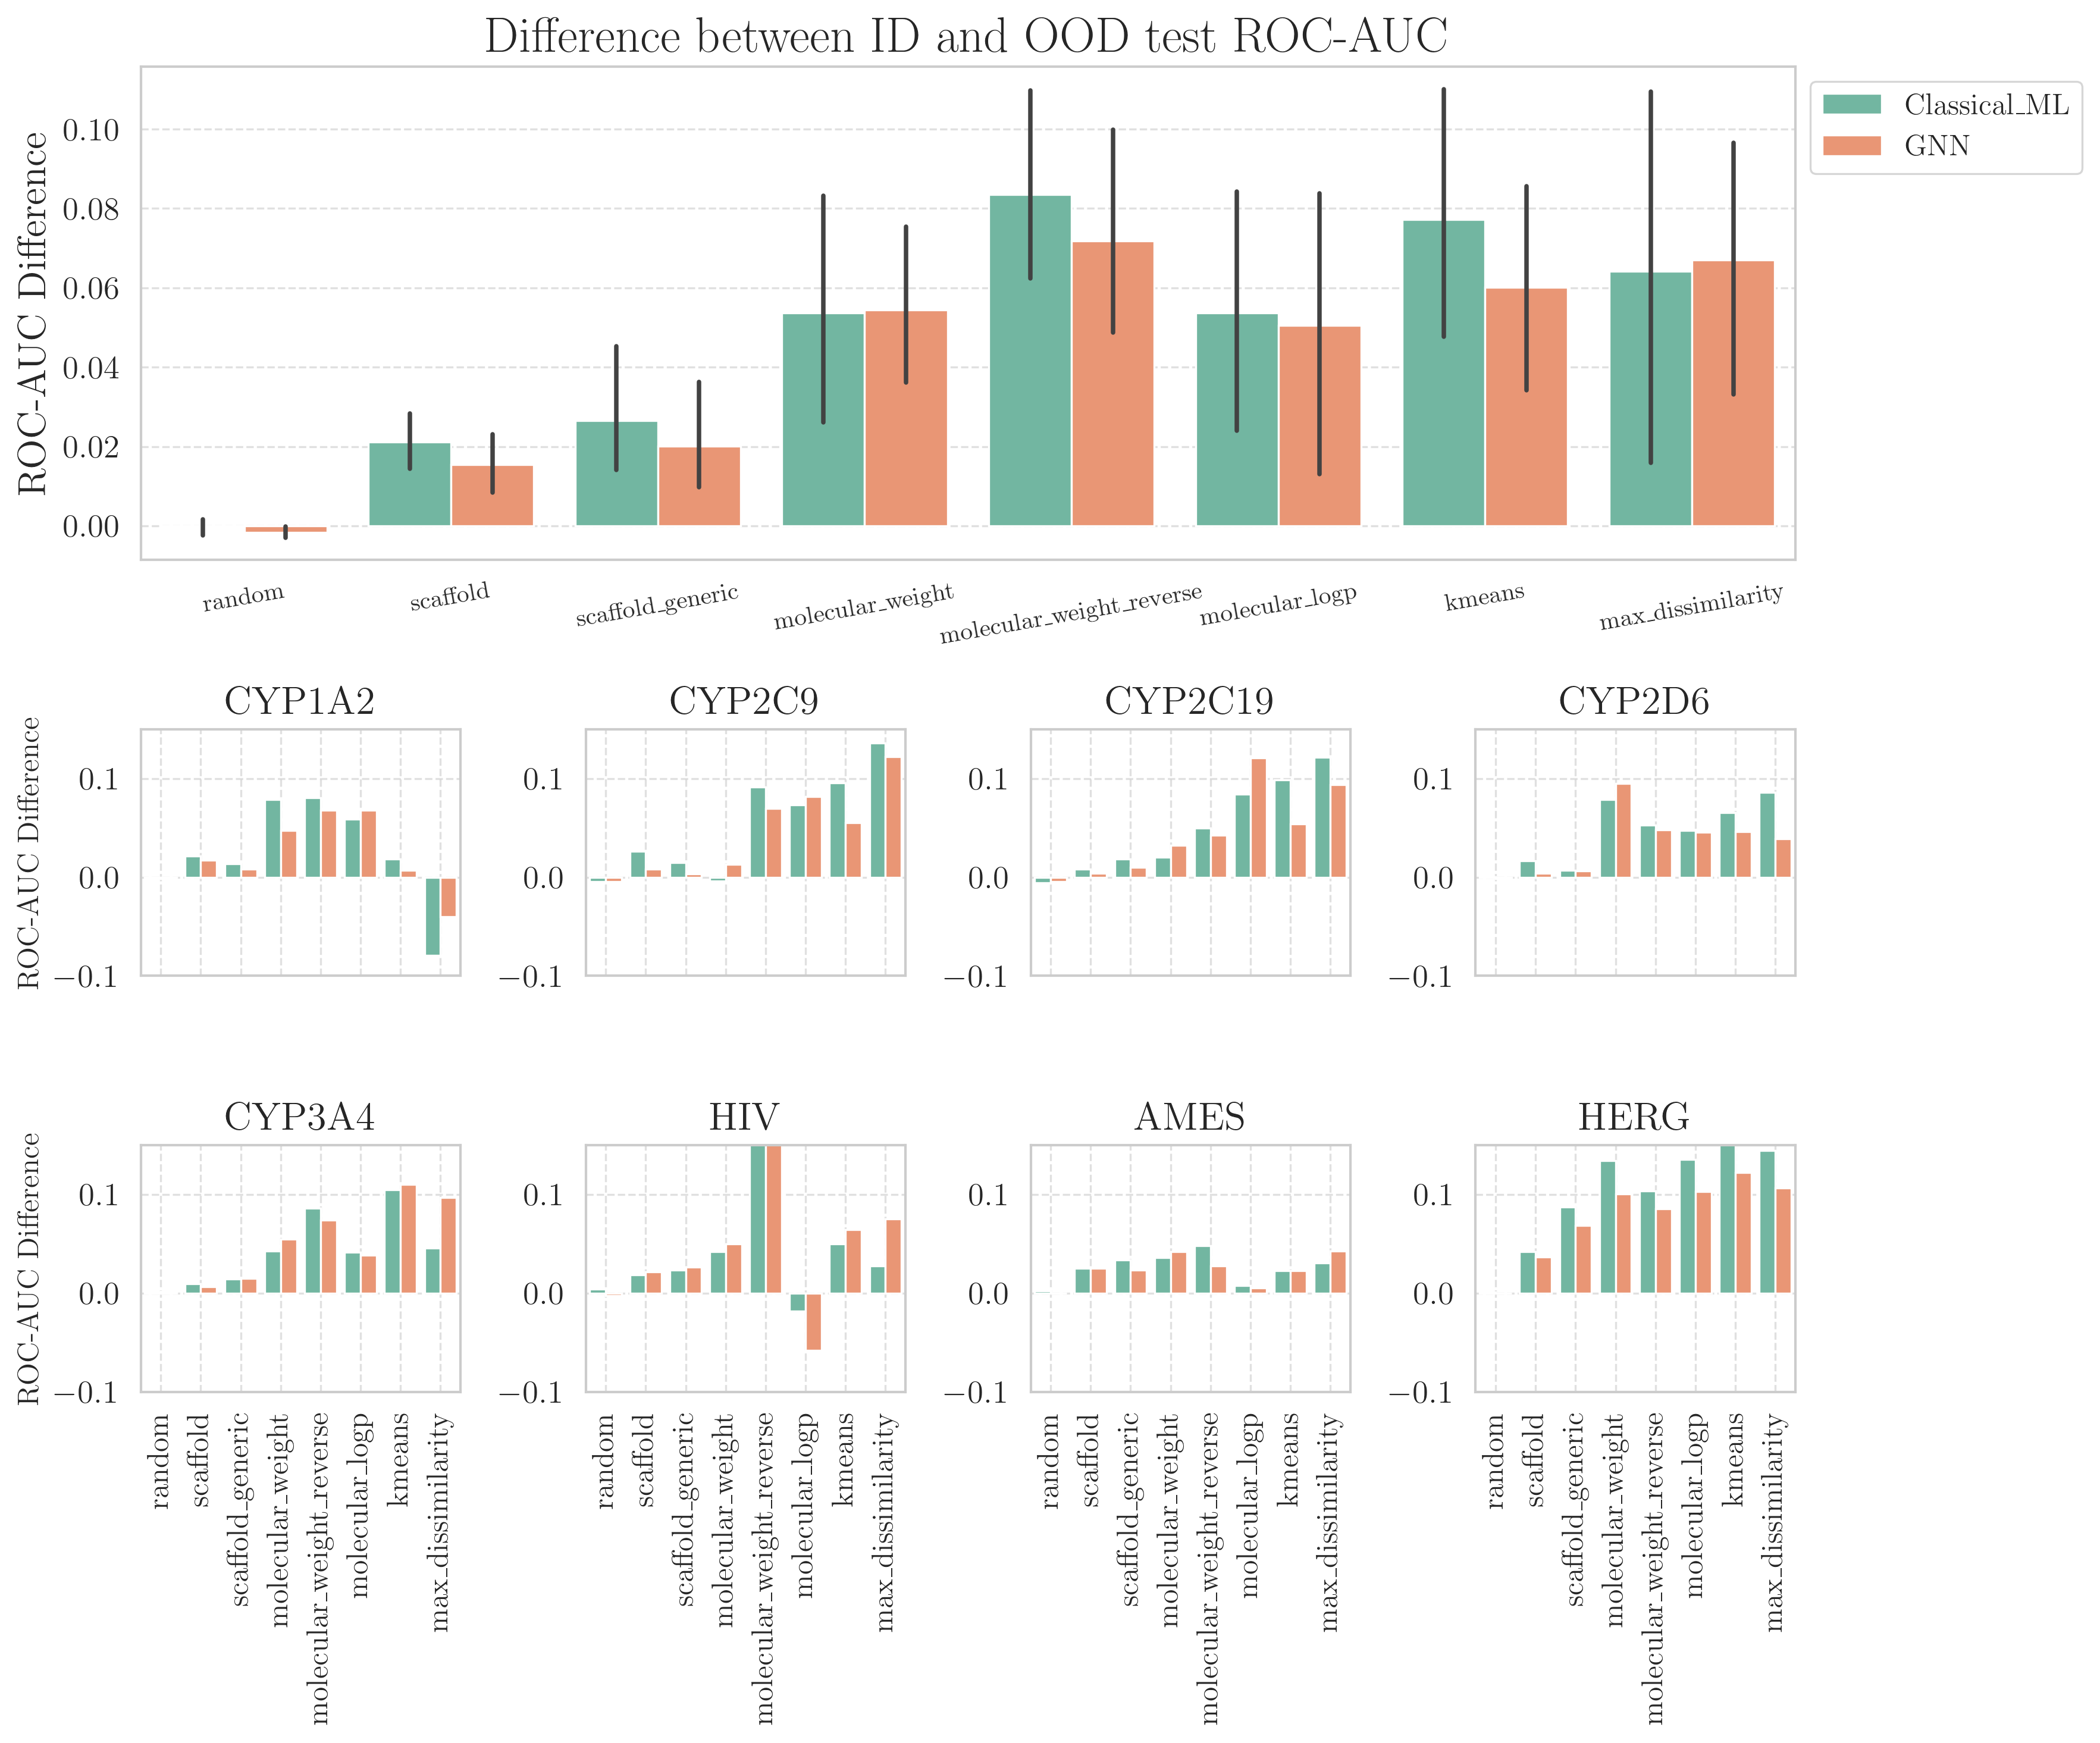

In [14]:
# Create grouped bar plot for ML vs GNN model differences
import matplotlib.gridspec as gridspec
save = True

results["model_type"] = results['model'].apply(lambda x: "Classical_ML" if x in ML_MODELS else "GNN")

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1])  # 3 rows, 4 columns

# First row: One wide subplot
ax1 = plt.subplot(gs[0:1, :])  # Spans all columns

# Second and third rows: 4x2 grid (8 subplots)
axes = [plt.subplot(gs[i, j]) for i in range(1, 3) for j in range(4)]


df = results.groupby(['split', 'model_type', 'dataset'])['difference'].mean().reset_index()

# rearrange the order of the split
split_order = SPLIT_TYPES
df['split'] = pd.Categorical(df['split'], split_order)

# For ax1, plot the difference between ML and GNN models
g = sns.barplot(x="split", y="difference", hue="model_type", data=df, ax=ax1, legend=True)
ax1.set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
ax1.set_xlabel("", fontsize=24)
ax1.set_ylabel(f"{metric_mapping[metric]} Difference", fontsize=16)
ax1.tick_params(axis='x', rotation=10, labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
# Move the legend outside the plot
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)




# for each dataset, create a small figure with the same plot
for i, dataset in enumerate(dataset_names):
    df_dataset = df[df["dataset"] == dataset]
    g = sns.barplot(x="split", y="difference", hue="model_type", data=df_dataset, ax=axes[i])


    # Customize the plot
    #axes[i].set_title(f"Difference between ID and OOD test {metric_mapping[metric]}", fontsize=20)
    # put x axis tixks just on the last rows and ignore other rows
    if i < 4:
        axes[i].set_xticklabels([])
    else:
        axes[i].tick_params(axis='x', rotation=90, labelsize=12, )
    axes[i].set_title(f"{dataset}", fontsize=16)
    axes[i].set_xlabel("", fontsize=18)
    axes[i].set_ylabel(f"{metric_mapping[metric]} Difference", fontsize=12)
    axes[i].grid(axis='both', linestyle='--', alpha=0.6)

    # Adjust legend
    g.legend().remove()  # Remove redundant legend
    # limit the range of yaxis betwen -0.1 to 0.15 with 0.05 interval
    axes[i].set_ylim(-0.1, 0.15)
    # remove y label for all subplots except the first one
    if i % 4 != 0:
        axes[i].set_ylabel("")

# Adjust layout to prevent label cutoff
plt.tight_layout()
if save:
    plt.savefig("assets/grouped_barplot_ml_gnn_difference.pdf", bbox_inches="tight")
    plt.savefig("assets/grouped_barplot_ml_gnn_difference.png", bbox_inches="tight", dpi=300)

plt.show()

In [10]:
df

['kmeans', 'max_dissimilarity', 'molecular_logp', 'molecular_weight', 'molecular_weight_reverse', 'random', 'scaffold', 'scaffold_generic']
Categories (8, object): ['random', 'scaffold', 'scaffold_generic', 'molecular_weight', 'molecular_weight_reverse', 'molecular_logp', 'kmeans', 'max_dissimilarity']

In [9]:
df = results.groupby(['split', 'model_type', 'dataset'])['difference'].mean().reset_index()


In [19]:
df1

split                     model_type
scaffold                  GNN           0.015419
                          ML            0.021066
scaffold_generic          GNN           0.020141
                          ML            0.026566
molecular_weight          GNN           0.054412
                          ML            0.053679
molecular_weight_reverse  GNN           0.071775
                          ML            0.083505
molecular_logp            GNN           0.050592
                          ML            0.053753
kmeans                    GNN           0.060145
                          ML            0.077269
max_dissimilarity         GNN           0.066984
                          ML            0.064224
Name: difference, dtype: float64

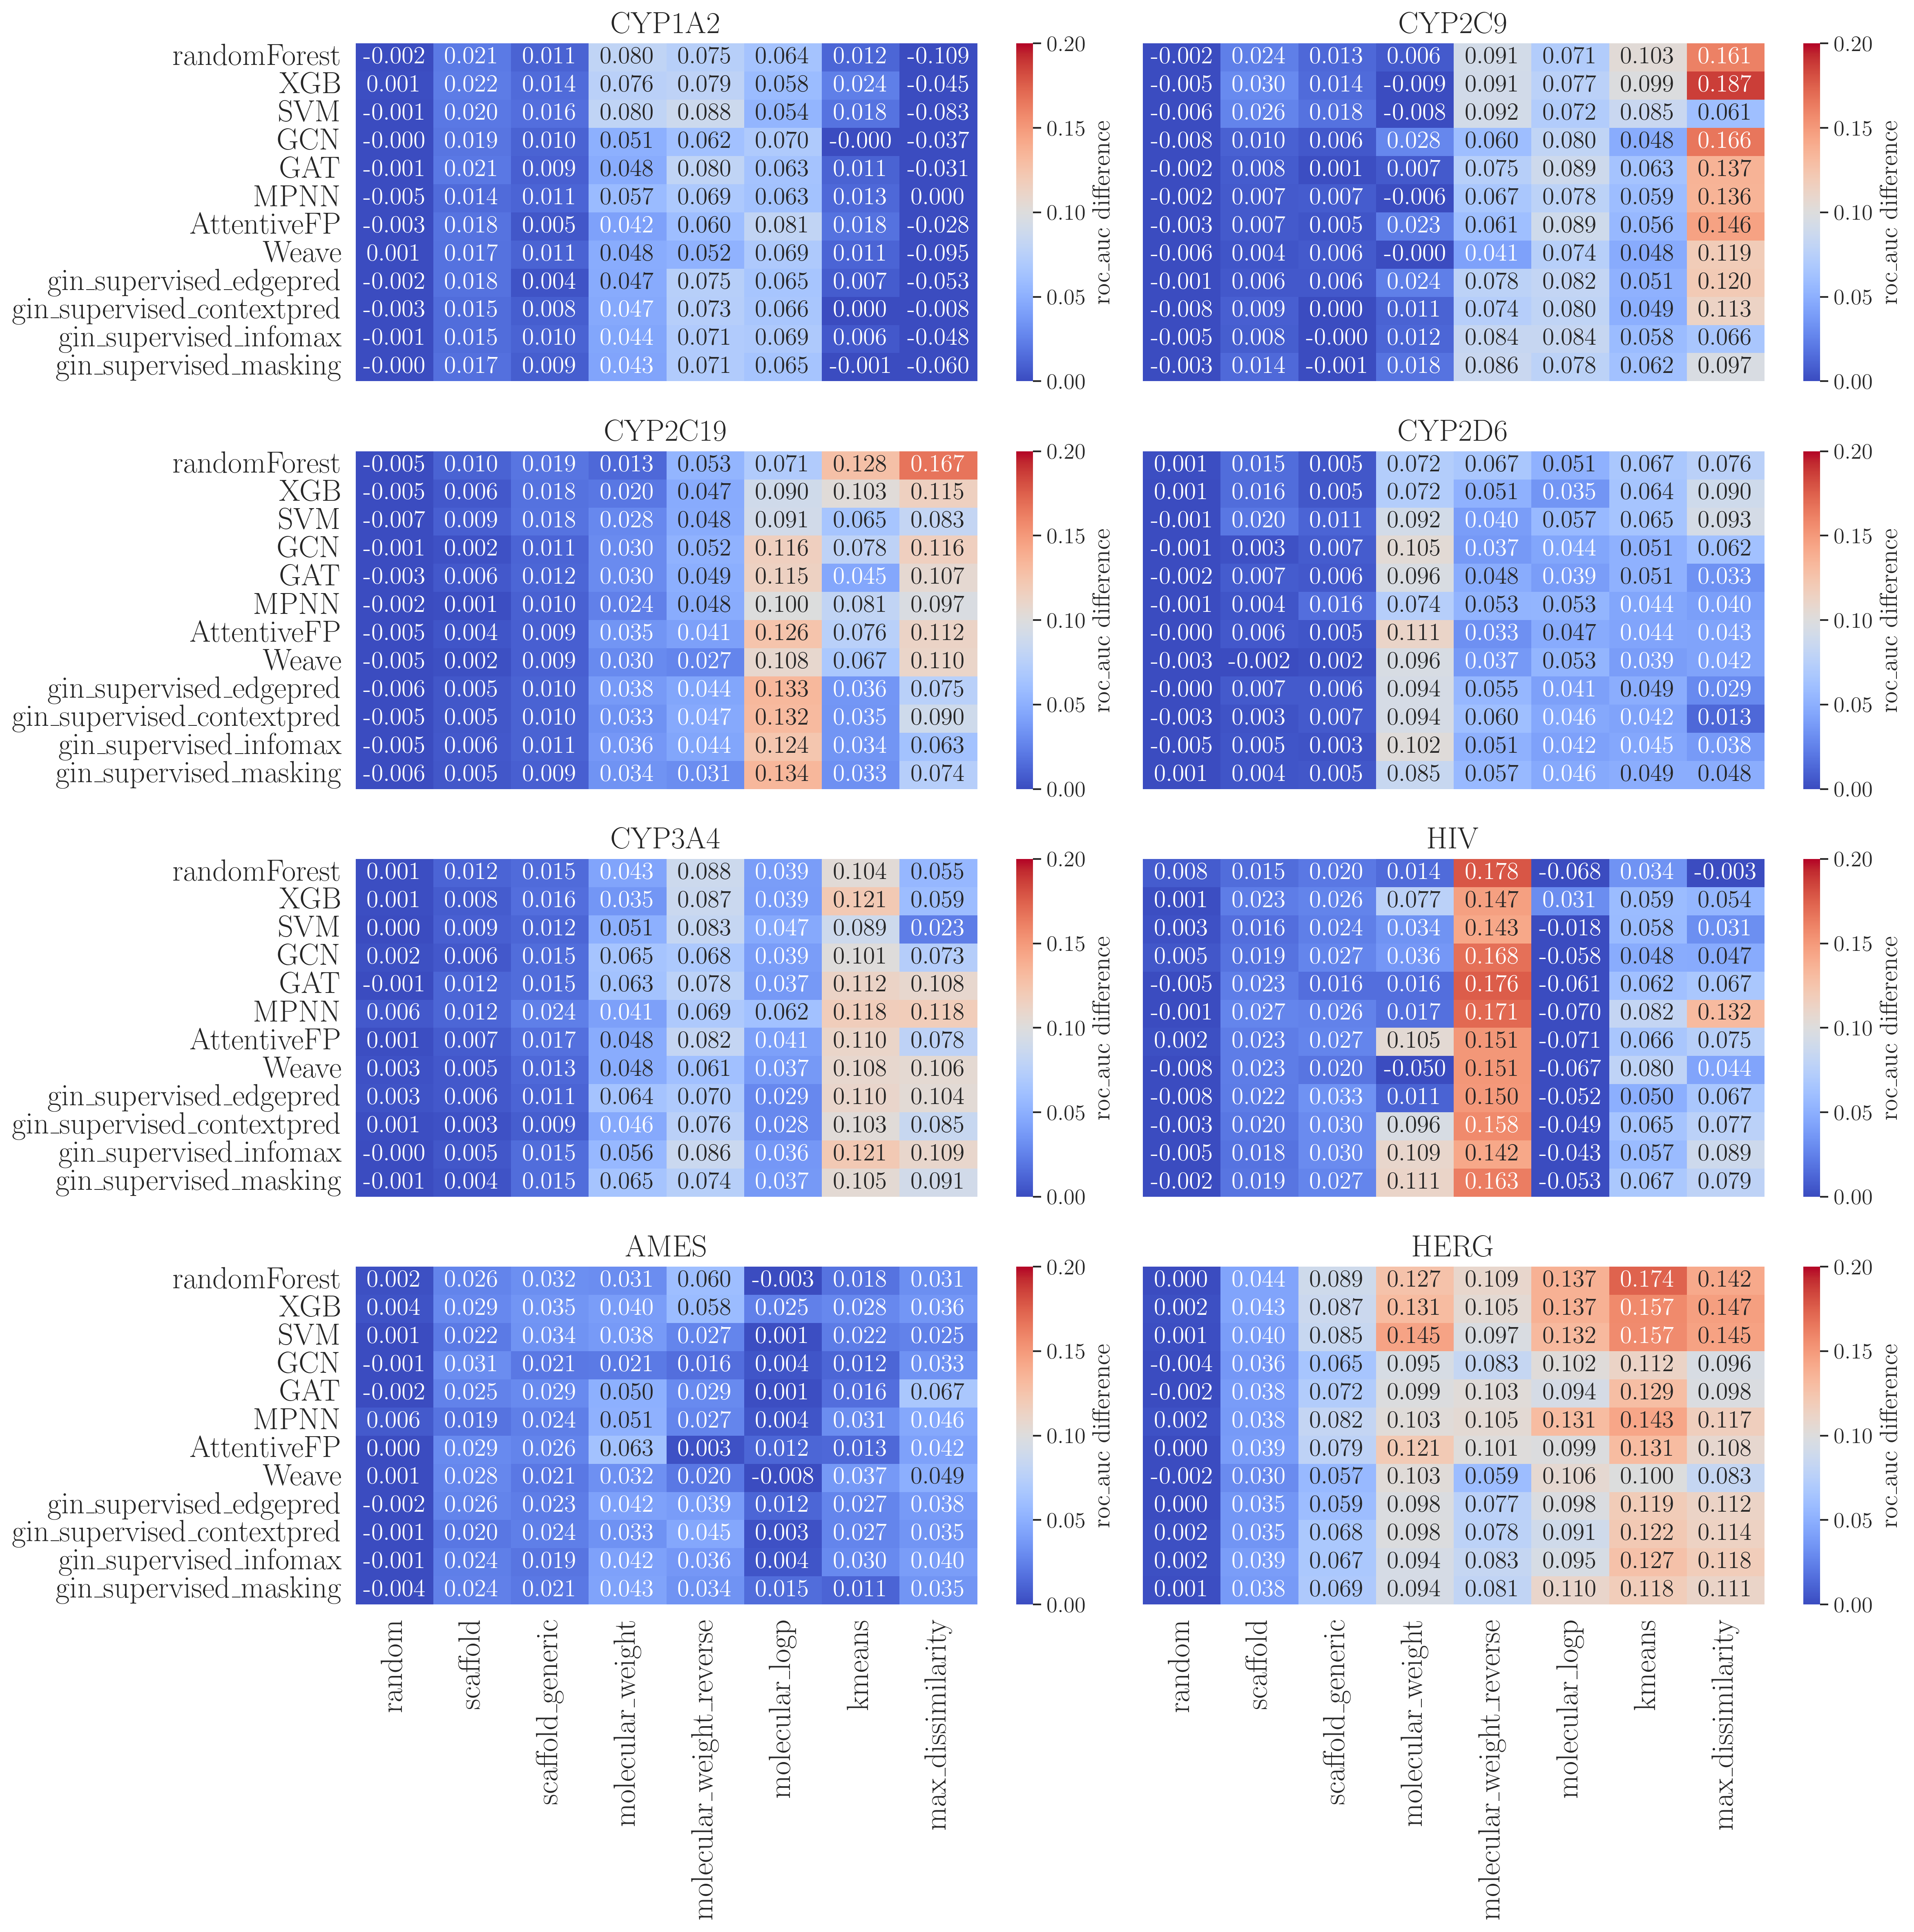

In [7]:
from alinemol.utils.plot_utils import heatmap_plot_all_dataset
#matplotlib.rcParams['figure.autolayout'] = True
heatmap_plot_all_dataset(results=results, metric="roc_auc", save=True)